## Dropout 2 -> 20, 40, 80

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchsummary import summary

In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 40
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((16, 16)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 16, 16])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 4, 7, 6, 5, 7, 3, 6, 9, 5])


In [ ]:
class CNN2Dropout(torch.nn.Module):
  def __init__(self, num_classes, drop_probas=[]):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.Dropout2d(p=drop_probas[0]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[1]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[2]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(64*2*2, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model2_dropout = CNN2Dropout(num_classes=10, drop_probas=[0.2, 0.4, 0.8])

In [ ]:
model2_dropout = model2_dropout.to(DEVICE)

In [ ]:
print(summary(model2_dropout, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
         Dropout2d-2           [-1, 16, 16, 16]               0
              ReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           2,080
         Dropout2d-6             [-1, 32, 8, 8]               0
              ReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Conv2d-9             [-1, 64, 4, 4]           8,256
        Dropout2d-10             [-1, 64, 4, 4]               0
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Linear-13                  [-1, 100]          25,700
             ReLU-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


In [ ]:
optimizer2_dropout = torch.optim.SGD(model2_dropout.parameters(), lr=0.1)
scheduler2_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2_dropout,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_dropout2, train_acc_list_dropout2, valid_acc_list_dropout2 = train_model(
    model=model2_dropout,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer2_dropout,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3082
Epoch: 001/040 | Batch 0100/0175 | Loss: 2.2980
Epoch: 001/040 | Train: 12.07% | Validation: 12.14%
Time elapsed: 1.31 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 2.2983
Epoch: 002/040 | Batch 0100/0175 | Loss: 2.2995
Epoch: 002/040 | Train: 21.12% | Validation: 21.26%
Time elapsed: 2.57 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 2.2701
Epoch: 003/040 | Batch 0100/0175 | Loss: 2.1783
Epoch: 003/040 | Train: 23.64% | Validation: 23.00%
Time elapsed: 3.88 min
Epoch: 004/040 | Batch 0000/0175 | Loss: 2.1585
Epoch: 004/040 | Batch 0100/0175 | Loss: 2.1167
Epoch: 004/040 | Train: 25.46% | Validation: 25.40%
Time elapsed: 5.18 min
Epoch: 005/040 | Batch 0000/0175 | Loss: 2.1266
Epoch: 005/040 | Batch 0100/0175 | Loss: 2.0400
Epoch: 005/040 | Train: 28.47% | Validation: 27.26%
Time elapsed: 6.51 min
Epoch: 006/040 | Batch 0000/0175 | Loss: 2.0364
Epoch: 006/040 | Batch 0100/0175 | Loss: 2.0298
Epoch: 006/040 | Train: 28.92% | Validation: 27.3

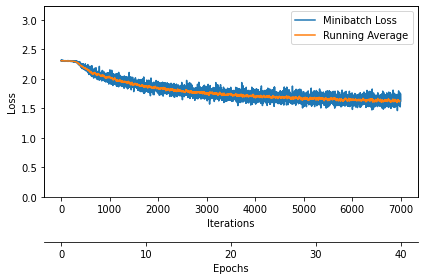

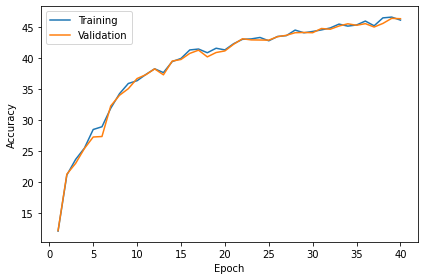

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_dropout2,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_dropout2,
              valid_acc_list=valid_acc_list_dropout2,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()

In [ ]:
class CNN1Dropout(torch.nn.Module):
  def __init__(self, num_classes, drop_probas=[]):
    super().__init__()
    self.features = torch.nn.Sequential(
            # Conv 1
            torch.nn.Conv2d(3, 16, kernel_size=3, padding="same"), # output 16 - 3 + 1 => 16
                            # , stride=4, padding=2),
            torch.nn.Dropout2d(p=drop_probas[0]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), # 16 / 2 => output 8

            # Conv 2
            torch.nn.Conv2d(16, 32, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 8
                            # , padding=2),
            torch.nn.Dropout2d(p=drop_probas[1]),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2), #output 8 / 2 => output 4

            # Conv 3
            # torch.nn.Conv2d(32, 64, kernel_size=2, padding="same"), # output 7 - 2 + 1 => 4
            #                 # , padding=2),
            # torch.nn.Dropout2d(p=drop_probas[2]),
            # torch.nn.ReLU(inplace=True),
            # torch.nn.MaxPool2d(kernel_size=2) #output 4 / 2 => output 2

    )

    self.classifier = torch.nn.Sequential(
         torch.nn.Linear(32*4*4, 100),
          torch.nn.ReLU(inplace=True),
          torch.nn.Linear(100, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    # print(x.size())
    logits = self.classifier(x)
    return logits

In [ ]:
model1_dropout = CNN1Dropout(num_classes=10, drop_probas=[0.2, 0.4, 0.8])

In [ ]:
model1_dropout = model1_dropout.to(DEVICE)

In [ ]:
print(summary(model1_dropout, (3, 16, 16)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
         Dropout2d-2           [-1, 16, 16, 16]               0
              ReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           2,080
         Dropout2d-6             [-1, 32, 8, 8]               0
              ReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                  [-1, 100]          51,300
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 54,838
Trainable params: 54,838
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
optimizer1_dropout = torch.optim.SGD(model1_dropout.parameters(), lr=0.1)
scheduler1_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1_dropout,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
minibatch_loss_list_dropout1, train_acc_list_dropout1, valid_acc_list_dropout1 = train_model(
    model=model1_dropout,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer1_dropout,
    device=DEVICE,
    scheduler=None,
    scheduler_on='valid_acc',
    logging_interval=100)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3095
Epoch: 001/040 | Batch 0100/0175 | Loss: 2.1519
Epoch: 001/040 | Train: 31.56% | Validation: 30.96%
Time elapsed: 1.50 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 2.0513
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.9043
Epoch: 002/040 | Train: 38.38% | Validation: 38.18%
Time elapsed: 2.99 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.8962
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.7297
Epoch: 003/040 | Train: 41.74% | Validation: 41.34%
Time elapsed: 4.49 min
Epoch: 004/040 | Batch 0000/0175 | Loss: 1.7341
Epoch: 004/040 | Batch 0100/0175 | Loss: 1.7107
Epoch: 004/040 | Train: 43.90% | Validation: 42.70%
Time elapsed: 5.96 min
Epoch: 005/040 | Batch 0000/0175 | Loss: 1.6439
Epoch: 005/040 | Batch 0100/0175 | Loss: 1.6308
Epoch: 005/040 | Train: 46.52% | Validation: 45.74%
Time elapsed: 7.46 min
Epoch: 006/040 | Batch 0000/0175 | Loss: 1.5650
Epoch: 006/040 | Batch 0100/0175 | Loss: 1.5583
Epoch: 006/040 | Train: 48.22% | Validation: 47.1

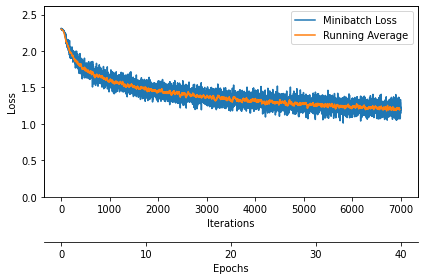

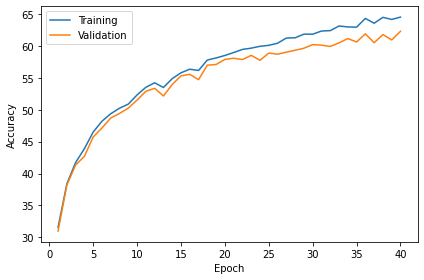

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list_dropout1,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list_dropout1,
              valid_acc_list=valid_acc_list_dropout1,
              results_dir=None)

# plt.ylim([80, 100])
plt.show()



























In [ ]:
import pandas as pd

In [ ]:
results = pd.DataFrame({"Number of Parameters": [54838, 37494], "Accuracy": [46, 64]}, index = ["CNN1", "CNN2"])

In [ ]:
results

,Number of Parameters,Accuracy
CNN1,54838,46
CNN2,37494,64


## Very surprisingly adding a 80% dropout on the last layer improved the efficiency many fold as it made the model simpler with very low overfitting. This could be the model I would consider running for longer time.